# TASK-2
### (Tried OCR to extract time stamp but it didn't work well on all images, so plot is between Number of people vs Frame Number)

## Import the necessary packages

In [1]:
from skimage.measure import compare_ssim
import imutils
import cv2
import glob
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
from math import floor
# from datetime import datetime

## Get all the images

In [2]:
images = sorted(glob.glob('*.jpg'))

## Find out the range of the table color for color thresholding

The type of this input is <class 'numpy.ndarray'>
Shape: (1080, 1920, 3)


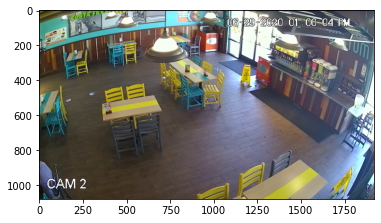

In [3]:
image_color = cv2.imread(images[0])
image_color = cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB)
print("The type of this input is {}".format(type(image_color)))
print("Shape: {}".format(image_color.shape))
plt.imshow(image_color)

In [4]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [5]:
# get the hex value of color present in the image
def get_colors(image, number_of_colors, show_chart):
    modified_image = image.reshape(image.shape[0]*image.shape[1], 3)
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    counts = Counter(labels)

    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    return rgb_colors

[array([101.25018658,  97.93296281, 104.04902662]),
 array([176.26367804, 163.84758803, 126.80540782]),
 array([52.38996907, 46.39733275, 38.10758737]),
 array([116.00348475, 135.50180797, 156.36325435]),
 array([172.2055332 , 163.23171219,  51.19953515]),
 array([158.64954882, 187.3690058 , 210.26525943]),
 array([238.9191937 , 249.77482866, 244.4831006 ]),
 array([74.51249967, 70.31772238, 70.95910449])]

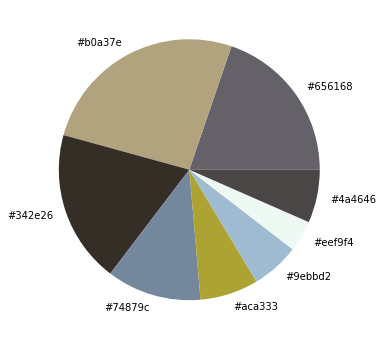

In [6]:
# get the pie chart of major 8 colors in the image
get_colors(image_color, 8, True)

## Get the coordinates of all the tables using color thresholding and contour generation

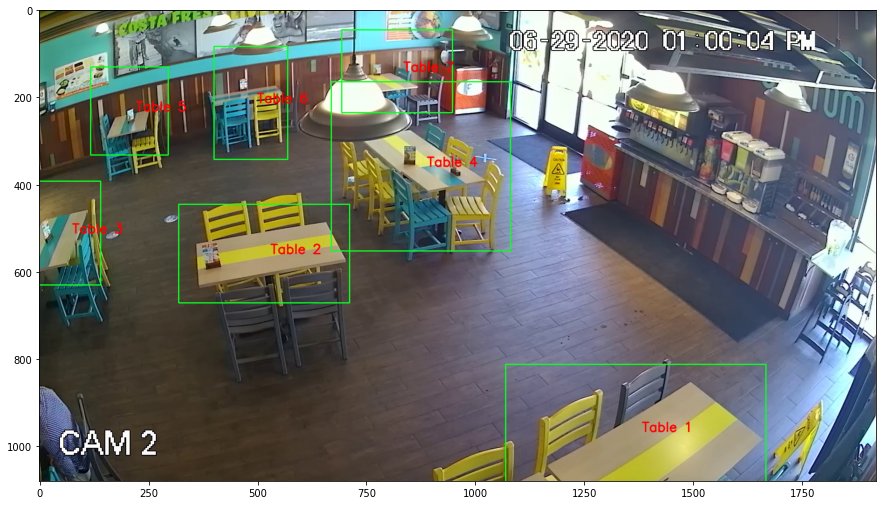

In [7]:
image = cv2.imread(images[0])
original = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

lower = np.array([145, 80, 80], dtype="uint8")
upper = np.array([255, 230, 180], dtype="uint8")
mask_table = cv2.inRange(image, lower, upper)
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(mask_table,kernel,iterations = 1)
dilation = cv2.dilate(erosion,kernel,iterations = 6)
mask_table = cv2.erode(dilation,kernel,iterations = 4)

# find contours in the generated mask
cnts = cv2.findContours(mask_table, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
tables = {}
i = 1

for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    area = h * w
    # get rid of small extra contours
    if  area > 15200 and area != 17484:
        cv2.rectangle(original, (x - 40, y - 40), (x + w + 10, y + h + 40), (36,255,12), 2)
        tables[i] = [(x - 40, y - 40), (x + w + 10, y + h + 40)]

        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(original,'Table ' + str(i),(floor(x + (w / 2)), floor(y + (h / 2))), font, 1,(0,0,255),2,cv2.LINE_AA)

        i += 1

plt.figure(figsize = (15, 15))
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
plt.imshow(original)

## Count the number of people at each table
- Step 1: Find the differnce between two consecutive frames
- Step 2: Use morphological operations to get rid of small contours
- Step 3: Generate contours and get the coordinates of the rectangle surrounding the contours
- Step 5: Get the center of each contours
- Step 6: Find the table in which the center of each contour lies by comparing coordinates
- Step 7: Count the number of people at each table

In [8]:
table_1 = np.zeros(len(images))
table_2 = np.zeros(len(images))
table_3 = np.zeros(len(images))
table_4 = np.zeros(len(images))
table_5 = np.zeros(len(images))
table_6 = np.zeros(len(images)) 
table_7 = np.zeros(len(images))

for i in range(len(images) - 1):
    image1 = cv2.imread(images[i])
    image2 = cv2.imread(images[i + 1])

    # compute difference
    difference = cv2.subtract(image1, image2)

    # color the mask red
    Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255,cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
    mask = np.where(mask > 0, 0, 1)
    mask = np.uint8(np.expand_dims(mask, axis=-1))

    kernel = np.ones((5,5),np.uint8)
    kernel1 = np.ones((3,3),np.uint8)
    mask = cv2.erode(mask,kernel1,iterations = 2)
    mask = cv2.dilate(mask,kernel,iterations = 12)
    mask = cv2.erode(mask,kernel,iterations = 17)
    mask = cv2.dilate(mask,kernel,iterations = 5)

    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    count_1 = 0
    count_2 = 0
    count_3 = 0
    count_4 = 0
    count_5 = 0
    count_6 = 0
    count_7 = 0

    for c in cnts:
    # compute the bounding box of the contour and then draw the

        (x, y, w, h) = cv2.boundingRect(c)
        center = (x + (w / 2), y + (h / 2))

        if tables[1][0][0] < center[0] < tables[1][1][0] and tables[1][0][1] < center[1] < tables[1][1][1]: 
            count_1 += 1
            # print('1')
        if tables[2][0][0] < center[0] < tables[2][1][0] and tables[2][0][1] < center[1] < tables[2][1][1]:
            count_2 += 1
            # print('2')
        if tables[3][0][0] < center[0] < tables[3][1][0] and tables[3][0][1] < center[1] < tables[3][1][1]:
            count_3 += 1
            # print('3')
        if tables[4][0][0] < center[0] < tables[4][1][0] and tables[4][0][1] < center[1] < tables[4][1][1]:
            count_4 += 1
            # print('4')
        if tables[5][0][0] < center[0] < tables[5][1][0] and tables[5][0][1] < center[1] < tables[5][1][1]:
            count_5 += 1
            # print('5')
        if tables[6][0][0] < center[0] < tables[6][1][0] and tables[6][0][1] < center[1] < tables[6][1][1]:
            count_6 += 1
            # print('6')
        if tables[7][0][0] < center[0] < tables[7][1][0] and tables[7][0][1] < center[1] < tables[7][1][1]:
            count_7 += 1
            # print('7')
    
    table_1[i + 1] = count_1
    table_2[i + 1] = count_2
    table_3[i + 1] = count_3
    table_4[i + 1] = count_4
    table_5[i + 1] = count_5
    table_6[i + 1] = count_6
    table_7[i + 1] = count_7

In [9]:
time_stamp = np.arange(len(images))

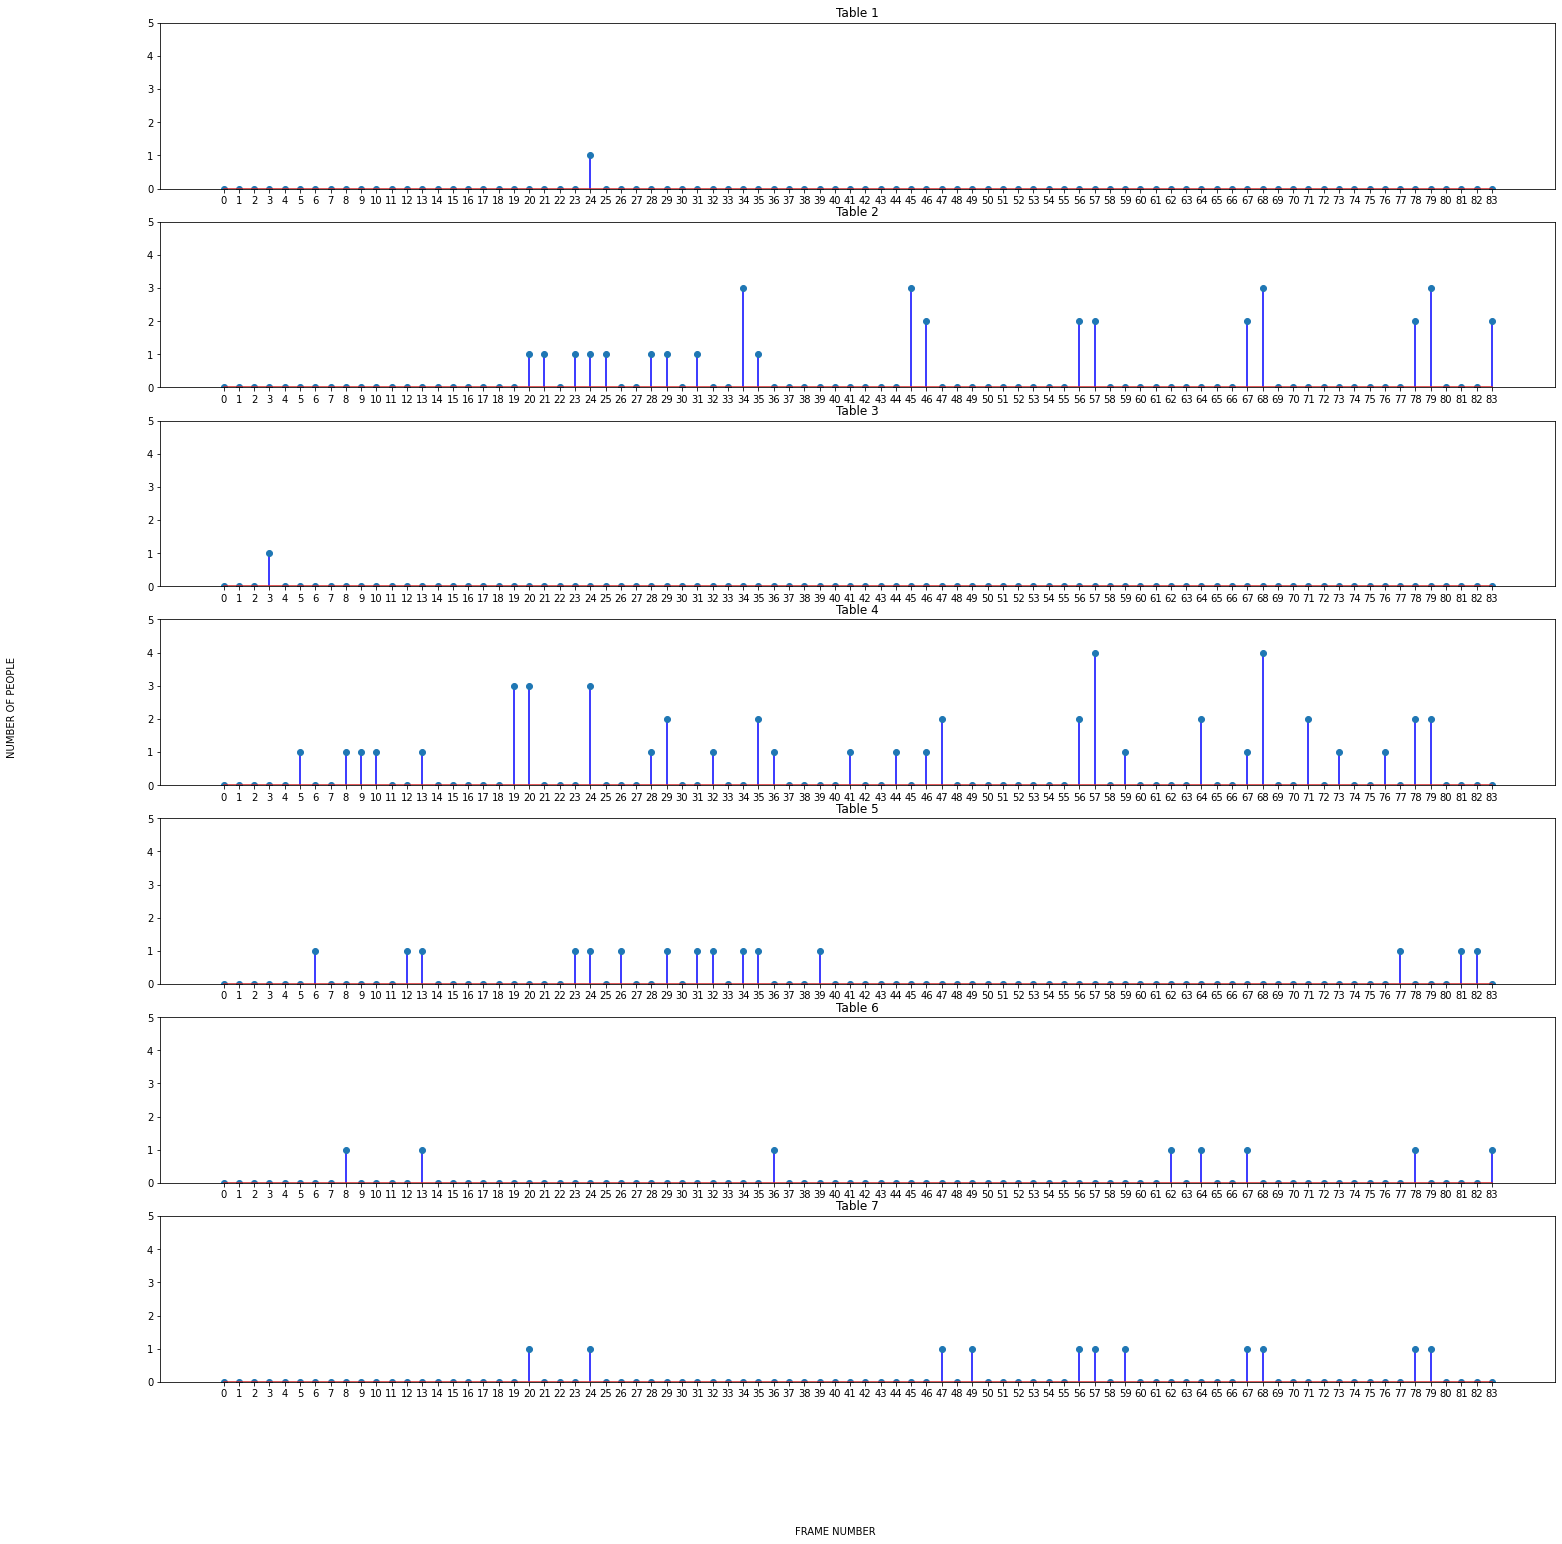

In [20]:
fig, ax = plt.subplots(nrows=7, ncols=1, sharex=True, sharey=True, figsize=(25, 25))
fig.text(0.5, 0.04, 'FRAME NUMBER', ha='center')
fig.text(0.04, 0.5, 'NUMBER OF PEOPLE', va='center', rotation='vertical')

table_all = [table_1, table_2, table_3, table_4, table_5, table_6, table_7]
for i in range(7):
    plt.subplot(7, 1, i + 1)
    plt.stem(time_stamp, table_all[i], 'ob')
    plt.ylim(0, 5)
    plt.xticks(time_stamp)
    plt.title('Table ' + str(i + 1))